# Statement Dates with Pyramid

No changes from original notebook https://www.kaggle.com/code/romaupgini/statement-dates-to-use-or-not-to-use ,  except to use as proof-of-concept and turbo-charge it with the pyramid technique. Much improved even with same training budget. I also did modify the final fold ensembling to a preferred method. Note I wasn't able to get deterministic behavior with this notebook, your results may vary but should be similar.

See here for another example of using the pyramid with my own notebook: https://www.kaggle.com/code/roberthatch/xgboost-pyramid-test-predictions

Below is from original notebook

# 📆 Statement dates - Is there any valuable information for feature engineering?
______________________________
*updated 2022-07-17 [@roma-upgini](https://www.kaggle.com/romaupgini)*  🗣 Share this notebook: [Shareable Link](https://www.kaggle.com/romaupgini/statement-dates-to-use-or-not-to-use)


## Four hypothesis on statement dates for feature engineering:

1️⃣ There is last statement date seasonality for default rate and we can increase prediction accuracy by adding time dependent features for the last statement date (sin, cos, number of day, week etc). We have 31 days of statements (from 03/01 till 03/31). So, we can only check weekly seasonality.  

2️⃣ There is an influence on default rate from holidays before/after the last statement, which might change income or spend structure for the households. We have to specify country for the holidays, but we can guess that for AMEX with a relatively high accuracy.  

3️⃣ There is an influence on default rate from local economic situation, like emloyment, price inflation rates, central bank rates etc. Same - we'll need a country for that. However, 31 days of March 2018 most probably won't be enough to catch correlation with macroeconomical situation on training phase. But we have test set for April 2019 (public LB part) and October 2019 (private LB part) with 13-19 month shift from train period - enough for macroeconomics influence. It's worth to try.  

4️⃣ Changes in statement dates for 13 month observation period has additional information correlated with default. From what I know about credit cards - consumer might change statement date, for example after salary date change. Which, in turn, might be the signal for employment change.

**Let's check them one by one.**
______________________________

## Packages and functions

📚 In this notebook we'll use:
* [Upgini](https://github.com/upgini/upgini#readme) - Free automated data and feature enrichment library for machine learning applications <a href="https://github.com/upgini/upgini">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white"  align='center'>
</a>
* [CuDF from RAPIDS.ai](https://github.com/rapidsai/cudf) - DataFrame on GPU

**Switch on Internet and GPU for this kernel!**

In [1]:
%pip install -Uq upgini
import pandas as pd, numpy as np
import sklearn
import matplotlib.pyplot as plt, gc, os
import seaborn as sns
import cupy, cudf

# RANDOM SEED
SEED = 42
# FILL NAN VALUE
NAN_VALUE = -127

def read_file2cudf(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    print('shape of data:', df.shape)
    return df

# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())
def lgb_amex_metric(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label()), True

# code by @https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos

    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight * (1 / weight.sum())).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / n_pos

    lorentz = (target * (1 / n_pos)).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max
    return 0.5 * (g + d)

# official metric
import pandas as pd
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

Note: you may need to restart the kernel to use updated packages.


## Quick data exploration - Last statement date

In [2]:
# train = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns=['S_2','customer_ID'])
# train['S_2'] = pd.to_datetime(train['S_2'])
# train = train.groupby('customer_ID')['S_2'].agg('max').reset_index() #last statement only

# df_train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
# train = train.merge(df_train_labels, on='customer_ID')
# del df_train_labels
# _ = gc.collect()
# print("Shape of data: ",train.shape)

First, let's check number of statements and default rates by day. Where **default rate** is a ratio of customers with default on specific date.

In [3]:
# plot_df=train.groupby("S_2").target.count()
# new_train = pd.DataFrame(train.groupby("S_2").target.mean())
# print (f"Number of days in train set: {new_train['target'].count()}")
# print (f"Standard deviation of Default ratio: {new_train['target'].std()}")

# fig, ax = plt.subplots(2,1,figsize = (20,8))
# plot_df.plot(title = "# Statements", ax = ax[0])
# new_train.plot(title = "% of Defaults", ax = ax[1])
# plt.show()
# del plot_df, ax, fig

Interesting, most likely there are
* either a strong card sales seasonality (most probably statement date derived from card activation date) - ie very few card sales on Sundays, and a big spike on Saturdays
* or strong preferences on statement dates by customers themselfs

>Disclaimer - I'm not an AMEX customer, but for most of the banks you can choose statement date, so I'm extrapolating here

Next, default ratio by day.  
There is a deviation between days, but it's hard to guess weither it is significant or not.
**And we have two options here:**
1. Let's assume it's a time series, where **y** is a Default Ratio. Then, if there is an influence like in Hypothesis #3 (macroeconomic influence), it must be some trend component in this TS. So we can check Stationarity of TS using [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test) with a significance level of less than 5%.  
The intuition behind this test is that it determines how strongly a time series is defined by a trend. However, there is a case, when it's doesn't help us - Hypothesis #1. As Augmented Dickey-Fuller test  won't detect seasonal component (it's a stationary TS). **So we have to use something different.**

2. Let's auto generate **A LOT** of features from Holiday calendars, Workweek calendars, Political calendars, Sport calendars, sin, cos for month/week, add economic indicators and financial market data by using any data enrichment library. Then do feature selection with feature permutation. In this case - only features which has a statistically significant influence on model accuracy will be picked up. **Here we'll be able to test ALL Hypothesis #1, #2, #3 AT ONCE.**

So let's do Option 2, as it's quicker, using [Upgini](https://github.com/upgini/upgini#readme) - Free automated data and feature enrichment library for machine learning applications.   
It will add automatically a lot of external information about dates, holidays, events, financial markets, consumer sentiments, weather etc. all for the specific country / location. Than automatically checks for relevance (ie influence on prediction accuracy improvement) and select only features which will improve it.  
Full [list of data scources and features, such as weather features, calendar features, financial features, etc ](https://github.com/upgini/upgini#-connected-data-sources-and-coverage)

## Hypothesis 1️⃣, 2️⃣, 3️⃣ test with Upgini automated data and feature enrichment library

To initiate search with Upgini library, you need to define so called [*search keys*](https://github.com/upgini/upgini#-search-key-types-we-support-more-is-coming) - a set of columns to join external data sources and features. In this competition we can use the following keys:

1. Column **date** should be used as **SearchKey.DATE**.;  
2. **Country** as "US" and "UK" (ISO-3166 country code), as most of AMEX customers are from US, next major market is UK.
    
With this set of search keys, our X dataset will be matched with [different date-specific features](https://github.com/upgini/upgini#-connected-data-sources-and-coverage), taking into account the country. Than relevant selection and ranking will be done.  
  
To start the search, we need to initiate *scikit-learn* compartible `FeaturesEnricher` transformer with appropriate **search** parameters.    
After that, we can call the **fit** or **fit_transform**  method of `features_enricher`.

In [4]:
# from upgini import FeaturesEnricher, SearchKey
# from upgini.dataset import Dataset

# enricher = FeaturesEnricher(
#     date_format="%Y-%m-%d",
#     search_keys={"S_2": SearchKey.DATE},
#     country_code = "US", # change that to UK for another run
# )
# Dataset.MIN_ROWS_COUNT = 20 #small X dataset, removed internal checks

For `FeaturesEnricher.fit()` method, just like in all scikit-learn transformers, we should pass **X_train** as the first argument and **y_train** as the second argument.   
**y_train** is needed to select **only relevant features & datasets, which will improve accuracy**. And rank new external features according to their prediction contribution, calculated as a SHAP values.  

In [5]:
# enricher.fit(
#     new_train.drop(columns="target").reset_index(),
#     new_train["target"]
# )
# del enricher, train, new_train
# _ = gc.collect()

### 🏁 Conclusion for Hypothesis #1, #2 and #3

**No relevant external features on dates found - both for US, and for UK.**  
So we have **to reject** Hypothesis #1,#2 and #3 for this training dataset.  

IMHO, there must be some influence, but to catch that, we need different training data structured in a following way:

1. 3 months of statements for default customers, minimum
2. gap window between months in 3 month set - at least 6 months  

Than we'll have 15 months observation window in a following schema: **1 + 6 months gap + 1 + 6 months gap + 1**

## Hypothesis 4️⃣ test, using optimized public notebook from [@cdeotte](https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793) (🙏)

Baseline Public score for this notebook was **0.793**, local CV **0.794**    
I made following impovements
* CV with Stratification and 4 Folds
* Changed CV metric from OOF Score to Average Score
* Removed features with changes in cals methodology between train and LBs: B_29 and S_9
* Added "after-pay" features
* Removed NaN replacement
* Permutation feature selection
* More feature eng. with additional statistics on last observations (1500+ features)
* Changed hyperparams for XGB

Public score after these changes **0.796** with local CV **0.79639** which is more consistent **"Local CV to LB match"** than before

Now, let's calculate features from statement dates distances and compare results on the Public LB after enrichment with this new features.   
For **quick** estimation we'll do 2 steps:
1. Calculate Distance between statement dates. Impute first observation / only one statement case with mean() value.
2. Calculate Stat. features for Statement dates distance column

### Quick feature engineering on distance between statement dates:

In [6]:
def feature_engineer(df):
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    
    # Initial feature selection to speed up fitting, based on @ambros
    # https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart/notebook
    features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
    features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_11', 'S_12', 'S_23', 'S_25']
    features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
    features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
    features_last = list(set(features_last)-set(cat_features))
    features_max = list(set(features_max)-set(cat_features))
    features_min = list(set(features_min)-set(cat_features))
    features_avg = list(set(features_avg)-set(cat_features))
    
    # Drop non stable features for train-test, based on % of NaNs
    #https://www.kaggle.com/code/onodera1/amex-eda-comparison-of-training-and-test-data    
    df.drop(["B_29","S_9"], axis=1, inplace = True)
    
    # Hypothesis #4 - retrieve info from statement dates as distance between the dates
    # Than calculate 'mean', 'std', 'max', 'last' statistics for distances
    # cudf doesn't support diff() as GroupBy function, slow pandas DF used
    temp = df[["customer_ID","S_2"]].to_pandas()
    temp["SDist"]=temp.groupby("customer_ID")["S_2"].diff() / np.timedelta64(1, 'D')
    # Impute with average distance 30.53 days
    temp['SDist'].fillna(30.53, inplace=True)
    df = cudf.concat([df,cudf.from_pandas(temp["SDist"])], axis=1)
    del temp
    _ = gc.collect()
    features_last.append('SDist')
    features_avg.append('SDist')
    features_max.append('SDist')
    features_min.append('SDist')
    
    #https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
    df.loc[(df.R_13==0) & (df.R_17==0) & (df.R_20==0) & (df.R_8==0), 'R_6'] = 0
    df.loc[df.B_39==-1, 'B_36'] = 0
    
    # Compute "after pay" features
    # https://www.kaggle.com/code/jiweiliu/rapids-cudf-feature-engineering-xgb
    for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
        for pcol in ['P_2','P_3']:
            if bcol in df.columns:
                df[[f'{bcol}-{pcol}']] = df[bcol] - df[pcol]
                features_last.append(f'{bcol}-{pcol}')
                features_avg.append(f'{bcol}-{pcol}')
                features_max.append(f'{bcol}-{pcol}')
                features_min.append(f'{bcol}-{pcol}')
                
    # BASIC FEATURE ENGINEERING
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    # https://www.kaggle.com/code/jiweiliu/rapids-cudf-feature-engineering-xgb
    
    test_num_last = df.groupby("customer_ID")[features_last].agg(['last','first'])
    test_num_last.columns = ['_'.join(x) for x in test_num_last.columns]
    test_num_min = df.groupby("customer_ID")[features_min].agg(['min'])
    test_num_min.columns = ['_'.join(x) for x in test_num_min.columns]
    test_num_max = df.groupby("customer_ID")[features_max].agg(['max'])
    test_num_max.columns = ['_'.join(x) for x in test_num_max.columns]
    test_num_avg = df.groupby("customer_ID")[features_avg].agg(['mean'])
    test_num_avg.columns = ['_'.join(x) for x in test_num_avg.columns]
    test_num_std = df.groupby("customer_ID")[list(set().union(features_avg,features_last,features_min,features_max))].agg(['std','quantile'])
    test_num_std.columns = ['_'.join(x) for x in test_num_std.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['last','first'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
   
    #add last statement date, statements count and "new customer" category (LT=0.5)
    test_date_agg = df.groupby("customer_ID")[["S_2","B_3","D_104"]].agg(['last','count'])
    test_date_agg.columns = ['_'.join(x) for x in test_date_agg.columns]
    test_date_agg.rename(columns = {'S_2_count':'LT','S_2_last':'S_2'}, inplace = True)
    test_date_agg.loc[(test_date_agg.B_3_last.isnull()) & (test_date_agg.LT==1),'LT'] = 0.5
    test_date_agg.loc[(test_date_agg.D_104_last.isnull()) & (test_date_agg.LT==1),'LT'] = 0.5
    test_date_agg.drop(["B_3_last","D_104_last","B_3_count","D_104_count"], axis=1, inplace = True)
    
    df = cudf.concat([test_date_agg, test_num_last, test_num_min, test_num_max, test_num_avg, test_num_std, test_cat_agg], axis=1)
    del test_date_agg, test_num_last, test_num_min, test_num_max, test_num_avg, test_num_std, test_cat_agg
    
    # Ratios/diffs on last values as features, based on @ragnar123
    # https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977
    for col in list(set().union(features_last,features_avg)):
        try:
            df[f'{col}_last_first_div'] = df[f'{col}_last'] / df[f'{col}_first']
            df[f'{col}_last_mean_sub'] = df[f'{col}_last'] - df[f'{col}_mean']
            df[f'{col}_last_mean_div'] = df[f'{col}_last'] / df[f'{col}_mean']
            df[f'{col}_last_max_div'] = df[f'{col}_last'] / df[f'{col}_max']
            df[f'{col}_last_min_div'] = df[f'{col}_last'] / df[f'{col}_min']
        except:
            pass
        
    print('shape after engineering', df.shape )
    return df

In [7]:
train = []
_ = gc.collect()
# raddar Kaggle dataset
# https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
PATH="../input/amex-data-integer-dtypes-parquet-format/train.parquet"
train = read_file2cudf(path = PATH)
train = feature_engineer(train)

# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
#targets = cudf.read_csv('/content/drive/MyDrive/colab/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# cudf merge above randomly shuffles rows
train = train.sort_index().reset_index()

# FEATURES
# remove S_2 from FEATURES list
FEATURES = train.columns[2:-1]
print(f'There are {len(FEATURES)} features!')

shape of data: (5531451, 190)
shape after engineering (458913, 1582)
There are 1581 features!


### XGB Training on GPU
Training with 4 folds, it will take 1h 30min on Kaggle's P100 GPU

#########################
### Fold 1
### Train size 344184 Valid size 114729
#########################
Learning Rate: 1.5600000000000003
[0]	train-logloss:0.26111	train-amex:0.75289	valid-logloss:0.26503	valid-amex:0.74434
[5]	train-logloss:0.20703	train-amex:0.81212	valid-logloss:0.22254	valid-amex:0.78465
[9]	train-logloss:0.19580	train-amex:0.83069	valid-logloss:0.21926	valid-amex:0.78885


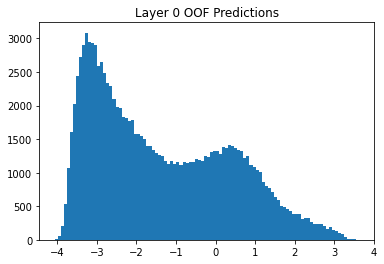

Learning Rate: 0.26
[0]	train-logloss:0.24286	train-amex:0.82694	valid-logloss:0.25579	valid-amex:0.78921
[25]	train-logloss:0.19683	train-amex:0.83048	valid-logloss:0.21945	valid-amex:0.78931
[49]	train-logloss:0.18769	train-amex:0.84514	valid-logloss:0.21738	valid-amex:0.79213


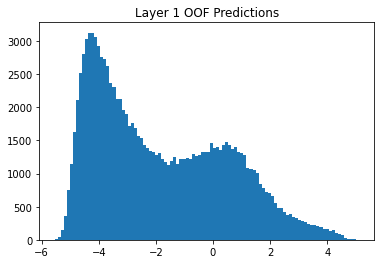

Learning Rate: 0.03125
[0]	train-logloss:0.21402	train-amex:0.84500	valid-logloss:0.23445	valid-amex:0.79204
[200]	train-logloss:0.18838	train-amex:0.84576	valid-logloss:0.21776	valid-amex:0.79236
[399]	train-logloss:0.18063	train-amex:0.85824	valid-logloss:0.21646	valid-amex:0.79359


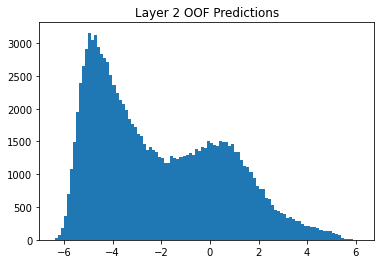

Learning Rate: 0.028125
[0]	train-logloss:0.19787	train-amex:0.85814	valid-logloss:0.22533	valid-amex:0.79360
[200]	train-logloss:0.18167	train-amex:0.85831	valid-logloss:0.21695	valid-amex:0.79349
[399]	train-logloss:0.17536	train-amex:0.86845	valid-logloss:0.21609	valid-amex:0.79407


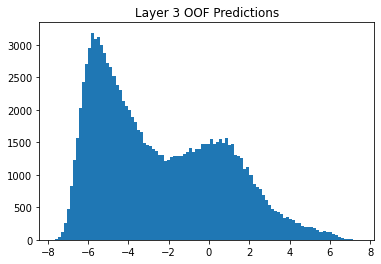

Learning Rate: 0.025
[0]	train-logloss:0.18226	train-amex:0.86833	valid-logloss:0.21825	valid-amex:0.79417
[200]	train-logloss:0.17375	train-amex:0.87268	valid-logloss:0.21601	valid-amex:0.79461
[400]	train-logloss:0.16878	train-amex:0.88063	valid-logloss:0.21559	valid-amex:0.79511
[600]	train-logloss:0.16390	train-amex:0.88904	valid-logloss:0.21538	valid-amex:0.79545
[800]	train-logloss:0.15931	train-amex:0.89703	valid-logloss:0.21527	valid-amex:0.79583
[1000]	train-logloss:0.15500	train-amex:0.90428	valid-logloss:0.21519	valid-amex:0.79591
[1199]	train-logloss:0.15063	train-amex:0.91203	valid-logloss:0.21508	valid-amex:0.79610


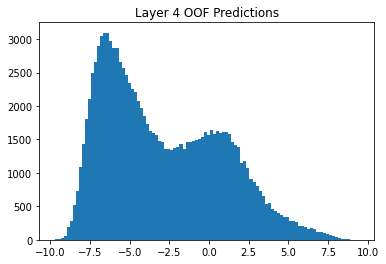

Learning Rate: 0.0125
[0]	train-logloss:0.15062	train-amex:0.91216	valid-logloss:0.21508	valid-amex:0.79610
[200]	train-logloss:0.14855	train-amex:0.91548	valid-logloss:0.21505	valid-amex:0.79620
[400]	train-logloss:0.14651	train-amex:0.91893	valid-logloss:0.21504	valid-amex:0.79633
[600]	train-logloss:0.14464	train-amex:0.92204	valid-logloss:0.21502	valid-amex:0.79648
[800]	train-logloss:0.14263	train-amex:0.92536	valid-logloss:0.21503	valid-amex:0.79644
[1000]	train-logloss:0.14074	train-amex:0.92851	valid-logloss:0.21502	valid-amex:0.79649
[1200]	train-logloss:0.13888	train-amex:0.93171	valid-logloss:0.21503	valid-amex:0.79673
[1400]	train-logloss:0.13706	train-amex:0.93445	valid-logloss:0.21503	valid-amex:0.79699
[1600]	train-logloss:0.13524	train-amex:0.93706	valid-logloss:0.21504	valid-amex:0.79682
[1800]	train-logloss:0.13340	train-amex:0.94014	valid-logloss:0.21503	valid-amex:0.79705
[2000]	train-logloss:0.13162	train-amex:0.94299	valid-logloss:0.21506	valid-amex:0.79749
[2200]

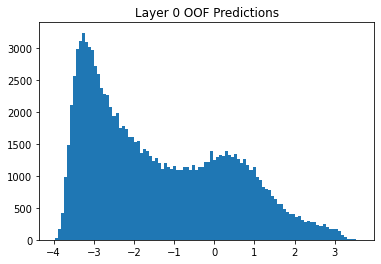

Learning Rate: 0.26
[0]	train-logloss:0.24234	train-amex:0.82836	valid-logloss:0.25478	valid-amex:0.78812
[25]	train-logloss:0.19638	train-amex:0.83225	valid-logloss:0.21942	valid-amex:0.78886
[49]	train-logloss:0.18669	train-amex:0.84781	valid-logloss:0.21742	valid-amex:0.79197


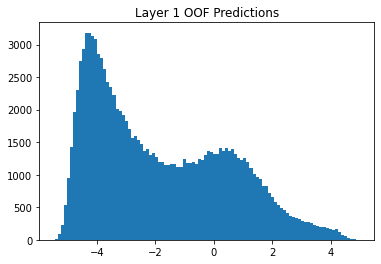

Learning Rate: 0.03125
[0]	train-logloss:0.21341	train-amex:0.84749	valid-logloss:0.23383	valid-amex:0.79208
[200]	train-logloss:0.18787	train-amex:0.84730	valid-logloss:0.21766	valid-amex:0.79286
[399]	train-logloss:0.17959	train-amex:0.86060	valid-logloss:0.21643	valid-amex:0.79429


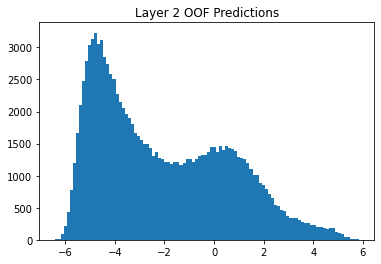

Learning Rate: 0.028125
[0]	train-logloss:0.19710	train-amex:0.86057	valid-logloss:0.22479	valid-amex:0.79435
[200]	train-logloss:0.18098	train-amex:0.86001	valid-logloss:0.21674	valid-amex:0.79384
[399]	train-logloss:0.17429	train-amex:0.87093	valid-logloss:0.21593	valid-amex:0.79424


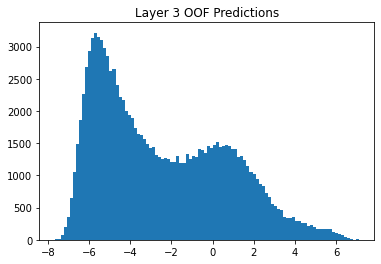

Learning Rate: 0.025
[0]	train-logloss:0.18130	train-amex:0.87084	valid-logloss:0.21783	valid-amex:0.79408
[200]	train-logloss:0.17287	train-amex:0.87462	valid-logloss:0.21584	valid-amex:0.79446
[400]	train-logloss:0.16774	train-amex:0.88279	valid-logloss:0.21540	valid-amex:0.79510
[600]	train-logloss:0.16265	train-amex:0.89165	valid-logloss:0.21517	valid-amex:0.79582
[800]	train-logloss:0.15805	train-amex:0.89974	valid-logloss:0.21507	valid-amex:0.79610
[1000]	train-logloss:0.15359	train-amex:0.90709	valid-logloss:0.21504	valid-amex:0.79612
[1199]	train-logloss:0.14928	train-amex:0.91463	valid-logloss:0.21504	valid-amex:0.79577


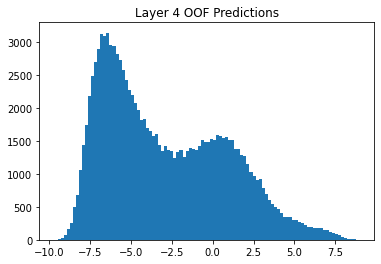

Learning Rate: 0.0125
[0]	train-logloss:0.14927	train-amex:0.91476	valid-logloss:0.21504	valid-amex:0.79577
[200]	train-logloss:0.14716	train-amex:0.91802	valid-logloss:0.21501	valid-amex:0.79592
[400]	train-logloss:0.14515	train-amex:0.92131	valid-logloss:0.21497	valid-amex:0.79629
[600]	train-logloss:0.14313	train-amex:0.92480	valid-logloss:0.21497	valid-amex:0.79620
[800]	train-logloss:0.14121	train-amex:0.92770	valid-logloss:0.21502	valid-amex:0.79556
[1000]	train-logloss:0.13933	train-amex:0.93061	valid-logloss:0.21502	valid-amex:0.79602
[1200]	train-logloss:0.13741	train-amex:0.93369	valid-logloss:0.21505	valid-amex:0.79619
[1400]	train-logloss:0.13554	train-amex:0.93647	valid-logloss:0.21507	valid-amex:0.79627
[1600]	train-logloss:0.13366	train-amex:0.93930	valid-logloss:0.21510	valid-amex:0.79625
[1800]	train-logloss:0.13181	train-amex:0.94183	valid-logloss:0.21512	valid-amex:0.79652
[2000]	train-logloss:0.13017	train-amex:0.94431	valid-logloss:0.21517	valid-amex:0.79638
[2200]

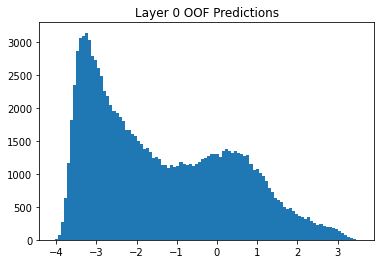

Learning Rate: 0.26
[0]	train-logloss:0.24167	train-amex:0.82861	valid-logloss:0.25667	valid-amex:0.78855
[25]	train-logloss:0.19585	train-amex:0.83225	valid-logloss:0.22107	valid-amex:0.78893
[49]	train-logloss:0.18669	train-amex:0.84740	valid-logloss:0.21912	valid-amex:0.79131


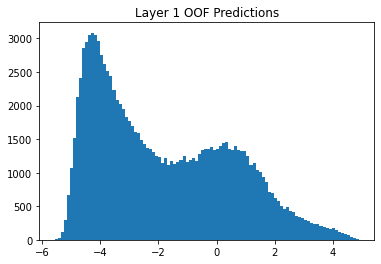

Learning Rate: 0.03125
[0]	train-logloss:0.21307	train-amex:0.84724	valid-logloss:0.23575	valid-amex:0.79122
[200]	train-logloss:0.18763	train-amex:0.84720	valid-logloss:0.21946	valid-amex:0.79216
[399]	train-logloss:0.17971	train-amex:0.86002	valid-logloss:0.21829	valid-amex:0.79359


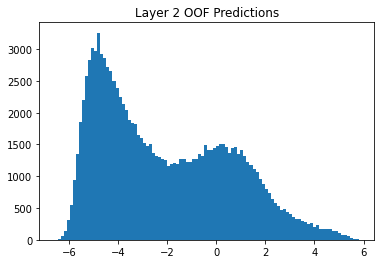

Learning Rate: 0.028125
[0]	train-logloss:0.19692	train-amex:0.85981	valid-logloss:0.22679	valid-amex:0.79333
[200]	train-logloss:0.18080	train-amex:0.85941	valid-logloss:0.21869	valid-amex:0.79268
[399]	train-logloss:0.17425	train-amex:0.87061	valid-logloss:0.21783	valid-amex:0.79431


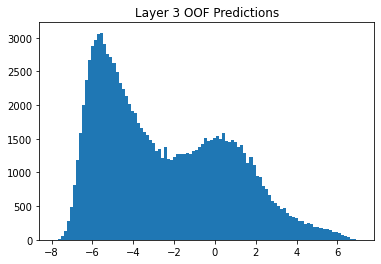

Learning Rate: 0.025
[0]	train-logloss:0.18118	train-amex:0.87062	valid-logloss:0.21986	valid-amex:0.79425
[200]	train-logloss:0.17282	train-amex:0.87424	valid-logloss:0.21775	valid-amex:0.79469
[400]	train-logloss:0.16772	train-amex:0.88245	valid-logloss:0.21732	valid-amex:0.79454
[600]	train-logloss:0.16258	train-amex:0.89117	valid-logloss:0.21710	valid-amex:0.79463
[800]	train-logloss:0.15766	train-amex:0.89975	valid-logloss:0.21706	valid-amex:0.79492
[1000]	train-logloss:0.15306	train-amex:0.90768	valid-logloss:0.21701	valid-amex:0.79483
[1199]	train-logloss:0.14883	train-amex:0.91463	valid-logloss:0.21694	valid-amex:0.79470


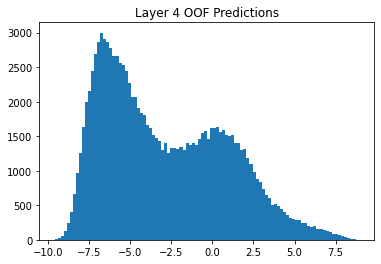

Learning Rate: 0.0125
[0]	train-logloss:0.14882	train-amex:0.91435	valid-logloss:0.21694	valid-amex:0.79470
[200]	train-logloss:0.14665	train-amex:0.91826	valid-logloss:0.21694	valid-amex:0.79465
[400]	train-logloss:0.14461	train-amex:0.92205	valid-logloss:0.21698	valid-amex:0.79448
[600]	train-logloss:0.14269	train-amex:0.92532	valid-logloss:0.21695	valid-amex:0.79427
[800]	train-logloss:0.14075	train-amex:0.92860	valid-logloss:0.21696	valid-amex:0.79416
[1000]	train-logloss:0.13887	train-amex:0.93152	valid-logloss:0.21696	valid-amex:0.79396
[1200]	train-logloss:0.13706	train-amex:0.93443	valid-logloss:0.21697	valid-amex:0.79437
[1400]	train-logloss:0.13518	train-amex:0.93728	valid-logloss:0.21695	valid-amex:0.79408
[1600]	train-logloss:0.13346	train-amex:0.93991	valid-logloss:0.21695	valid-amex:0.79409
[1800]	train-logloss:0.13171	train-amex:0.94259	valid-logloss:0.21697	valid-amex:0.79393
[1845]	train-logloss:0.13132	train-amex:0.94322	valid-logloss:0.21695	valid-amex:0.79394
Kaggle

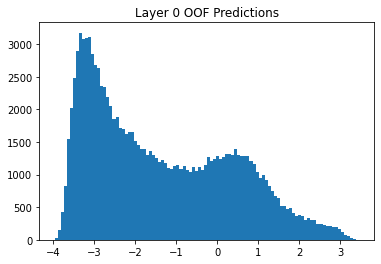

Learning Rate: 0.26
[0]	train-logloss:0.24266	train-amex:0.82801	valid-logloss:0.25440	valid-amex:0.79050
[25]	train-logloss:0.19684	train-amex:0.83138	valid-logloss:0.21783	valid-amex:0.79272
[49]	train-logloss:0.18728	train-amex:0.84715	valid-logloss:0.21585	valid-amex:0.79415


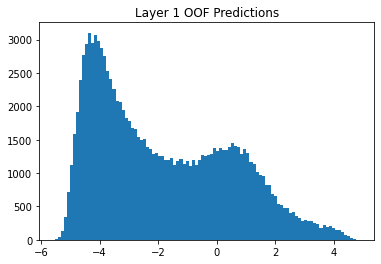

Learning Rate: 0.03125
[0]	train-logloss:0.21389	train-amex:0.84692	valid-logloss:0.23320	valid-amex:0.79410
[200]	train-logloss:0.18814	train-amex:0.84711	valid-logloss:0.21622	valid-amex:0.79366
[399]	train-logloss:0.18018	train-amex:0.85994	valid-logloss:0.21497	valid-amex:0.79611


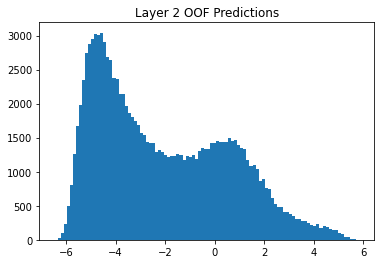

Learning Rate: 0.028125
[0]	train-logloss:0.19760	train-amex:0.85978	valid-logloss:0.22403	valid-amex:0.79581
[200]	train-logloss:0.18143	train-amex:0.85914	valid-logloss:0.21540	valid-amex:0.79487
[399]	train-logloss:0.17481	train-amex:0.86979	valid-logloss:0.21460	valid-amex:0.79640


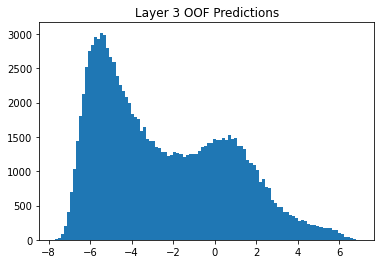

Learning Rate: 0.025
[0]	train-logloss:0.18179	train-amex:0.86981	valid-logloss:0.21686	valid-amex:0.79631
[200]	train-logloss:0.17325	train-amex:0.87390	valid-logloss:0.21453	valid-amex:0.79646
[400]	train-logloss:0.16808	train-amex:0.88237	valid-logloss:0.21415	valid-amex:0.79641
[600]	train-logloss:0.16325	train-amex:0.89082	valid-logloss:0.21390	valid-amex:0.79698
[800]	train-logloss:0.15855	train-amex:0.89888	valid-logloss:0.21376	valid-amex:0.79739
[1000]	train-logloss:0.15400	train-amex:0.90648	valid-logloss:0.21364	valid-amex:0.79730
[1199]	train-logloss:0.14990	train-amex:0.91314	valid-logloss:0.21360	valid-amex:0.79714


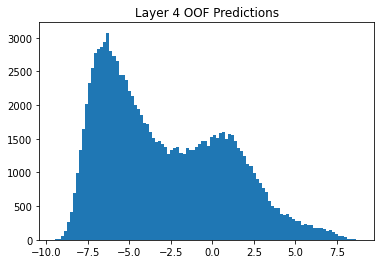

Learning Rate: 0.0125
[0]	train-logloss:0.14988	train-amex:0.91314	valid-logloss:0.21360	valid-amex:0.79725
[200]	train-logloss:0.14777	train-amex:0.91694	valid-logloss:0.21356	valid-amex:0.79746
[400]	train-logloss:0.14582	train-amex:0.92029	valid-logloss:0.21354	valid-amex:0.79783
[600]	train-logloss:0.14387	train-amex:0.92361	valid-logloss:0.21355	valid-amex:0.79750
[800]	train-logloss:0.14192	train-amex:0.92643	valid-logloss:0.21353	valid-amex:0.79760
[1000]	train-logloss:0.14000	train-amex:0.92979	valid-logloss:0.21353	valid-amex:0.79770
[1200]	train-logloss:0.13816	train-amex:0.93263	valid-logloss:0.21355	valid-amex:0.79716
[1400]	train-logloss:0.13638	train-amex:0.93526	valid-logloss:0.21355	valid-amex:0.79693
[1600]	train-logloss:0.13451	train-amex:0.93809	valid-logloss:0.21357	valid-amex:0.79674
[1800]	train-logloss:0.13265	train-amex:0.94099	valid-logloss:0.21358	valid-amex:0.79681
[2000]	train-logloss:0.13081	train-amex:0.94359	valid-logloss:0.21359	valid-amex:0.79680
[2190]

In [8]:
%%time
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# FOLDS PER MODEL, as number of weeks in a month
FOLDS = 4

# XGB MODEL PARAMETERS
BASE_LEARNING_RATE = 0.025
PYRAMID_W = [0.5, 2/3, 0.75, 0.875, 1, 0]
xgb_parms = {
            'objective': 'binary:logistic', 
            'tree_method': 'gpu_hist',
            'predictor':'gpu_predictor',
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.1,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda': 50,
            'random_state':SEED,

            'num_parallel_tree':1
    }

importances = []
oof = []
_ = gc.collect()

for j, cat_index in enumerate ([train[train.LT>0].index]):
    score = 0
    skf = StratifiedKFold(n_splits=FOLDS, shuffle = True, random_state=SEED)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(
                train.loc[cat_index,:][["customer_ID"]],
                train.loc[cat_index,:].target.values.get())):


        print('#'*25)
        print('### Fold',fold+1)
        print('### Train size',len(train_idx),'Valid size',len(valid_idx))
        print('#'*25)
        
        print("WARNING: non-deterministic behavior with same random seed, perhaps the column order is not guaranteed? Haven't found the root issue in this notebook.")

        # TRAIN, VALID, TEST FOR FOLD K
        y_valid = train.loc[valid_idx, 'target']
        dtrain = xgb.DMatrix(data=train.loc[train_idx, FEATURES],
                             label=train.loc[train_idx, 'target'],
                             )
        dvalid = xgb.DMatrix(data=train.loc[valid_idx, FEATURES],
                             label=y_valid,
                             )
        
        # TRAIN MODEL FOLD K
        # PYRAMID: Smoothly go from diverse forest of early trees into focused boosted trees correcting residuals.
        #   final layer must have w==0
        #   columns:    forest|boost|adj_eta|w
        pyramid_layers = [( 40,  10,  1.56,  0.5),
                          (  8,  50,  1.3,   2/3),
                          (  1, 400,  1.25,  0.75),
                          (  1, 400,  1.125, 0.875),
                          (  1,1200,  1.0,   1),
                          (  1,5200,  0.5,   0)]
        assert(PYRAMID_W == [layer[-1] for layer in pyramid_layers])
        for (layer, (n_trees, n_rounds, adj_learning, w)) in enumerate(pyramid_layers):
            ## Load the manual parameters from the pyramid layer
            xgb_parms['num_parallel_tree'] = n_trees
            xgb_parms['learning_rate'] = n_trees*adj_learning*BASE_LEARNING_RATE

            ## No early stopping except on final round. This is important since the weighting causes the model to go backwards for a time at the start of the next layer.
            early_stop = None
            if w == 0:
                early_stop = 1800

            print("Learning Rate:", xgb_parms['learning_rate'])
            model = xgb.train(xgb_parms, 
                        dtrain=dtrain,
                        evals=[(dtrain,'train'),(dvalid,'valid')],
                        num_boost_round=n_rounds,
                        early_stopping_rounds=early_stop,
                        custom_metric=xgb_amex,
                        maximize=True,
                        verbose_eval=200//n_trees)
            model.save_model(f'XGB_fold{fold}_LT{j}_layer{layer}.json')

            ## predict to load the predictions on the next model layer
            ## Don't set base margin on final layer. w = 0 is used as an encoded way to skip this step.
            if (w != 0):
                ptrain = model.predict(dtrain, output_margin=True)
                pvalid = model.predict(dvalid, output_margin=True)

                ## reduce the impact of all model layers so far by w. This should be another way to reduce over-specialization, without the computational cost of DART
                if (w < 1.0):
                    ptrain = ptrain * w
                    pvalid = pvalid * w

                ## This set_base_margin on the DMatrix data is what informs the next layer of the prior training.
                ## See code example from official demos: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/boost_from_prediction.py
                dtrain.set_base_margin(ptrain)
                dvalid.set_base_margin(pvalid)

                plt.hist(pvalid, bins=100)
                plt.title(f'Layer {layer} OOF Predictions')
                plt.show()

                del model, ptrain, pvalid
                gc.collect()

        del dtrain
        _ = gc.collect()

        # GET FEATURE IMPORTANCE FOR FOLD K
        dd = model.get_score(importance_type='weight')
        df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
        importances.append(df)

        # INFER OOF FOLD K
        oof_preds = model.predict(dvalid, iteration_range=(0,model.best_ntree_limit))
        acc = amex_metric(pd.DataFrame({'target':y_valid.values.get()}), 
                                        pd.DataFrame({'prediction':oof_preds}))
        print('Kaggle Metric =',acc,'\n')
        score += acc

        # SAVE OOF
        df = train.loc[valid_idx, ['customer_ID','target'] ].to_pandas()
        df['oof_pred'] = oof_preds
        oof.append( df )

        del dvalid, y_valid, model, dd, df
        _ = gc.collect()

    score /= FOLDS
    print('Average CV Kaggle Metric for group =',score)

print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
score = amex_metric(pd.DataFrame({'target':oof.target.values}), 
                                pd.DataFrame({'prediction':oof.oof_pred.values}))
print('OOF CV Kaggle Metric =',score)
# CLEAN RAM
del oof, skf, cat_index
del train
_ = gc.collect()

Local CV with the new features has a score **0.7964**  
Baseline solution without Statement distance features had **0.79639** on local CV, which is slightly less.   
Keep going.

### Feature importance of Statement Dates features
Let's check feature importance for TOP 20 vars and for "SDist" vars (derived from Statement dates distance)

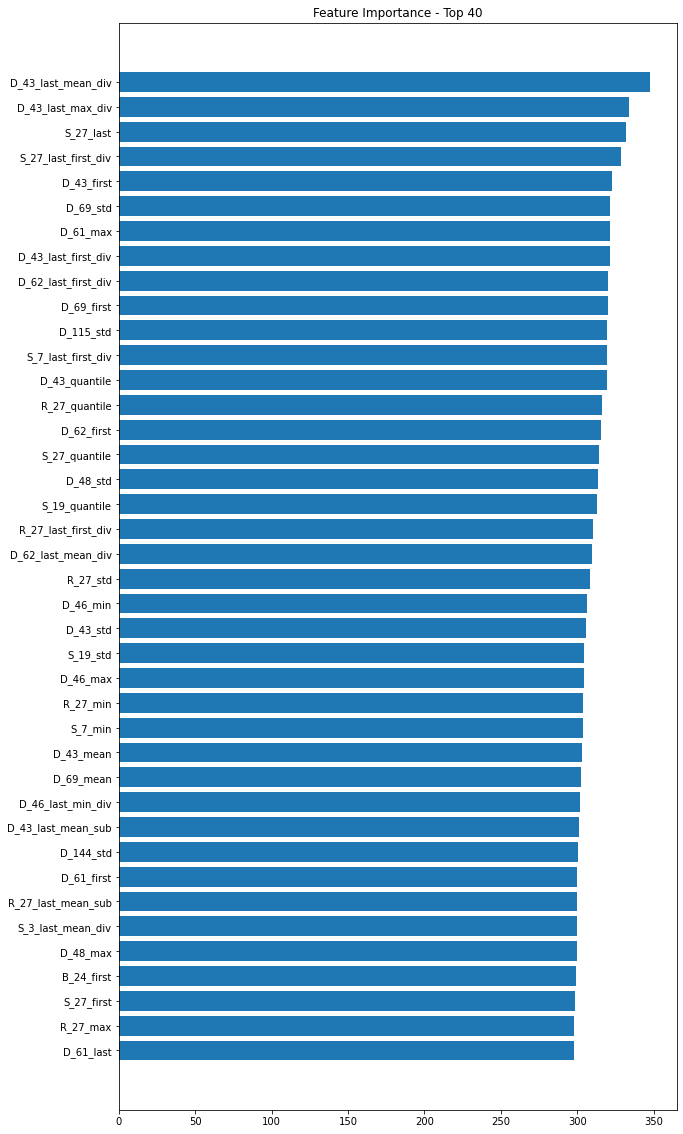

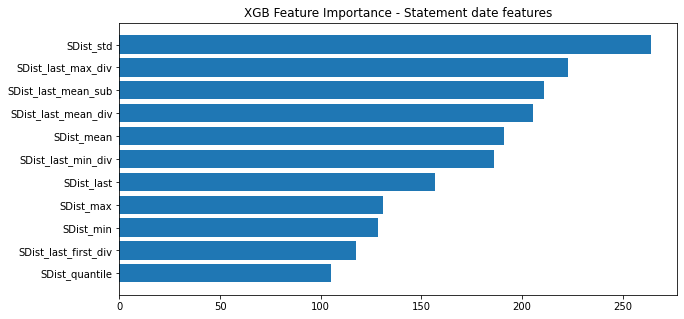

In [9]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS*(j+1)): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)

NUM_FEATURES = 40
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'Feature Importance - Top {NUM_FEATURES}')
plt.show()

df = df[df.feature.str.find("SDis") != -1]
plt.figure(figsize=(10,5*df.shape[0]//10))
plt.barh(np.arange(df.shape[0],0,-1), df.importance.values[:df.shape[0]])
plt.yticks(np.arange(df.shape[0],0,-1), df.feature.values[:df.shape[0]])
plt.title(f'XGB Feature Importance - Statement date features')
plt.show()

del df, plt, importances
_ = gc.collect()

**11 features** from Statement distance was selected, but none of them in TOP 40.   
So we might notice small improvement from them on Public LB.  
Let's check that.  

### Process Test Data, Predict and Submit
We will load @raddar dataset from [here][1] with discussion [here][2].

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514

In [10]:
# gc.collect()

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = read_file2cudf(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file2cudf(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape)
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = feature_engineer(test)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust

    for j, cat_index in enumerate ([test[test.LT>0].index]):
        # XGB
        dtest = xgb.DMatrix(data=test.loc[cat_index,:][FEATURES])
        
        ## Added Pyramid processing implementation here

        ## Need to reset to level 0 between folds.
        reset_margin = dtest.get_base_margin()

        pred_folds = []
        for f in range(FOLDS):
            if (f > 0):
                dtest.set_base_margin(reset_margin)
            for (layer, w) in enumerate(PYRAMID_W[:-1]):
                model = xgb.Booster()
                model.load_model(f'XGB_fold{f}_LT{j}_layer{layer}.json')
                print(f'Loaded fold{f}, layer{layer}')
                ptest = model.predict(dtest, output_margin=True)

                ## reduce the impact of all model layers so far by w. This should be another way to reduce over-specialization, without the computational cost of DART
                if (w < 1.0):
                    ptest = ptest * w

                ## This set_base_margin is what informs the next layer of the prior training.
                ## See code example from official demos: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/boost_from_prediction.py
                dtest.set_base_margin(ptest)

            layer = len(PYRAMID_W) - 1
            model = xgb.Booster()
            model.load_model(f'XGB_fold{f}_LT{j}_layer{layer}.json')

            ## Use custom method for ensembling the folds, normalized rank averaged with predicted probability
            ##   So get true probability not logitraw.
            preds = model.predict(dtest, iteration_range=(0,model.best_ntree_limit))

            ## Create nested array to combine all predictions of a single fold together to rank them before averaging the predictions across folds.
            if f == len(test_preds):
                test_preds.append([])
            test_preds[f].append(preds)
        # CLEAN MEMORY
        del dtest, model, reset_margin
        _ = gc.collect()

    del test
    _ = gc.collect()



Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]

Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1582)
Loaded fold0, layer0
Loaded fold0, layer1
Loaded fold0, layer2
Loaded fold0, layer3
Loaded fold0, layer4
Loaded fold1, layer0
Loaded fold1, layer1
Loaded fold1, layer2
Loaded fold1, layer3
Loaded fold1, layer4
Loaded fold2, layer0
Loaded fold2, layer1
Loaded fold2, layer2
Loaded fold2, layer3
Loaded fold2, layer4
Loaded fold3, layer0
Loaded fold3, layer1
Loaded fold3, layer2
Loaded fold3, layer3
Loaded fold3, layer4

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1582)
Loaded fold0, layer0
Loaded fold0, layer1
Loaded fold0, layer2
Loaded fold0

In [11]:
def values_to_rank(p):
    u, v = np.unique(p, return_inverse=True)
    result = (np.cumsum(np.bincount(v)) - 1)[v]
    result = result.astype(np.float64) + p
    return result

def values_and_rank(p):
    u, v = np.unique(p, return_inverse=True)
    result = (np.cumsum(np.bincount(v)) - 1)[v]
    result = result / len(p)
    result = (result + p) / 2
    return result

final_preds = []
for preds in test_preds:
    preds = np.concatenate(preds)
    print(np.unique(preds).shape)
    preds = values_and_rank(preds)
    final_preds.append(preds)

test_preds = final_preds[0]
for i in range(1, len(final_preds)):
    test_preds += final_preds[i]
print(np.unique(test_preds).shape[0])
print(test_preds)
print(test_preds.shape[0])

(901224,)
(900446,)
(902853,)
(902630,)
924621
[1.00550695 0.23110081 1.10506221 ... 2.24274348 1.96212942 1.23401165]
924621


In [12]:
# WRITE SUBMISSION FILE
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission.csv',index=False)
print('Submission file shape is', sub.shape )

Submission file shape is (924621, 2)


### 🏁 Conclusion for Hypothesis #4

Submission with the new features has a score **0.796** on Public LB, and that's more than **0.796** for baseline solution, based on 4th digit after point. Which is not shown ;-).   
Hint - you can check that ranking despite LB rounding to 3 digits in Edit mode -> Competitions. It actually shows what notebook version had maximum Public LB score WITHOUT rounding to 3 digits under the hood (BEST SCORE vs. LATEST SCORE).

We've got a small improvement both on Local CV and Public LB, as result - for this train-test datasets **we can accept** Hypothesis #4: *Changes in statement dates for 13 month observation period has additional information correlated with default*   

### 🚀 Useful links with data and feature enrichment guides   

#### [Guide #1 How to improve accuracy of Kaggle TOP1 leaderboard notebook in 10 minutes](https://www.kaggle.com/code/romaupgini/how-to-find-external-data-for-1-private-lb-4-50)
#### [Guide #2 Zero feature engineering with low-code libraries: Upgini + PyCaret](https://www.kaggle.com/code/romaupgini/zero-feature-engineering-with-upgini-pycaret)
#### [Guide #3 How to improve accuracy of Multivariate Time Series kernel from external features & data](https://www.kaggle.com/code/romaupgini/guide-external-data-features-for-multivariatets)  


#### Happy kaggling! 
<sup>😔 Found error in the library or a bug in notebook code? Our bad! <a href="https://github.com/upgini/upgini/issues/new?assignees=&title=readme%2Fbug">
Please report it here.</a></sup>